In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/optuna/study/_optimize.py:29: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from optuna import progress_bar as pbar_module


In [2]:
data_dir = "/lustre/groups/ml01/workspace/cell_flow_zebrafish/results/single_condition/cell_type_proportion"
output_dir = "/lustre/groups/ml01/workspace/cell_flow_zebrafish/results/single_condition/cell_type_proportion_downstream"

In [3]:

adata = sc.read_h5ad("/lustre/groups/ml01/workspace/ot_perturbation/data/zebrafish_new/zebrafish_processed.h5ad")

In [4]:
df_counts = adata.obs.groupby(["condition","cell_type_broad"]).size().to_frame(name="n_cells")


/tmp/ipykernel_1925910/2853154197.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_counts = adata.obs.groupby(["condition","cell_type_broad"]).size().to_frame(name="n_cells")


In [5]:
df_counts = df_counts.reset_index()

In [6]:
ood_conditions = ['zc4h2_control_24','met_control_36','tfap2a_control_72','hgfa_control_48','tfap2a_foxd3_72','noto_control_18','cdx4_cdx1a_36','epha4a_control_48','mafba_control_36','tbx16_msgn1_24','noto_control_24','smo_control_18','hand2_control_24','noto_control_36','egr2b_control_36','cdx4_control_18','tfap2a_control_36','foxi1_control_72','egr2b_control_24','cdx4_control_36','zc4h2_control_36','hoxb1a_control_48','tfap2a_foxd3_36','tbx16_tbx16l_24','smo_control_36','mafba_control_18','hgfa_control_72','tbx16_control_18','mafba_control_24','tbx1_control_36','zc4h2_control_48','wnt3a_wnt8_36','foxi1_control_48','smo_control_24','noto_control_48','mafba_control_48','tfap2a_control_48','hand2_control_48','egr2b_control_48','phox2a_control_48','tbx1_control_48','tbx16_msgn1_36','foxd3_control_72','wnt3a_wnt8_24','egr2b_control_18','wnt3a_wnt8_18','met_control_72','phox2a_control_36','epha4a_control_24','foxd3_control_36','tfap2a_foxd3_48','hand2_control_36','cdx4_cdx1a_24','hgfa_control_36','tbx16_tbx16l_18','tbxta_control_36','cdx4_control_24','foxd3_control_48','met_control_48','tbx1_control_24','epha4a_control_36','cdx4_cdx1a_18','tbx16_control_36','tbx16_tbx16l_36','tbx16_control_24','tbxta_control_24','tbx16_msgn1_18','epha4a_control_18','tbxta_control_18','hoxb1a_control_36','hoxb1a_control_24']
      

In [7]:
spearman_corrs = {}
pearson_corrs = {}
max_logratios = {}
dfs = []
for ood_cond in ood_conditions:
    csv_file = [el for el in os.listdir(data_dir) if ((ood_cond in el) and ("csv" in el))]
    if len(csv_file)==0:
        continue
    assert len(csv_file) == 1
    df = pd.read_csv(os.path.join(data_dir, csv_file[0]))
    spearman_corrs[ood_cond] = df[["logratio_true", "logratio_pred"]].corr("spearman").iloc[0,1]
    pearson_corrs[ood_cond] = df[["logratio_true", "logratio_pred"]].corr("pearson").iloc[0,1]
    max_logratios[ood_cond] = np.abs(df["logratio_true"]).max()
    df["condition"] = f"{ood_cond}"
    dfs.append(df)

In [8]:
df_pred = pd.concat(dfs)
df_pred["gene_target"] = df_pred.apply(lambda x: "_".join(x["condition"].split("_")[:2]), axis=1)
df_pred["timepoint"] = df_pred.apply(lambda x: int(x["condition"].split("_")[-1]), axis=1)

In [9]:
df_pred.head()

,cell_type_broad_transfer,ratio_pred,ratio_true,logratio_true,logratio_pred,condition,gene_target,timepoint
0,periderm,1.182168,1.349712,0.432652,0.241436,zc4h2_control_24,zc4h2_control,24
1,mature fast muscle,1.177825,1.242196,0.312892,0.236125,zc4h2_control_24,zc4h2_control,24
2,connective tissue-meninges-dermal FB,1.046386,0.899433,-0.152912,0.065415,zc4h2_control_24,zc4h2_control,24
3,neural progenitor (hindbrain),0.864279,0.775667,-0.366491,-0.210431,zc4h2_control_24,zc4h2_control,24
4,mature slow muscle,0.975546,1.205383,0.269492,-0.035718,zc4h2_control_24,zc4h2_control,24


In [10]:
df_baseline = pd.read_csv("/lustre/groups/ml01/workspace/cell_flow_zebrafish/results/single_condition/cell_type_proportion_baseline/all_single_oligo_ratios.csv", index_col=0)


In [11]:
df_baseline["cell_type_broad_transfer"] = df_baseline.index
df_baseline = df_baseline.rename(columns={"logratio_oligo": "logratio_pred", "ratio_olgo": "logratio_pred"})
df_baseline["mode"] = "single_oligo"
df_pred["mode"] = "CellFlow"

In [23]:
spearman_corrs = {}
pearson_corrs = {}
max_logratios = {}
dfs = []
for ood_cond in ood_conditions:
    csv_file = [el for el in os.listdir(data_dir) if ((ood_cond in el) and ("csv" in el))]
    if len(csv_file)==0:
        continue
    assert len(csv_file) == 1
    df = pd.read_csv(os.path.join("/lustre/groups/ml01/workspace/cell_flow_zebrafish/results/single_condition/cell_type_proportion_mean_model", csv_file[0]))
    spearman_corrs[ood_cond] = df[["logratio_true", "logratio_pred"]].corr("spearman").iloc[0,1]
    pearson_corrs[ood_cond] = df[["logratio_true", "logratio_pred"]].corr("pearson").iloc[0,1]
    max_logratios[ood_cond] = np.abs(df["logratio_true"]).max()
    df["condition"] = f"{ood_cond}"
    dfs.append(df)
df_mean = pd.concat(dfs)
df_mean["gene_target"] = df_mean.apply(lambda x: "_".join(x["condition"].split("_")[:2]), axis=1)
df_mean["timepoint"] = df_mean.apply(lambda x: int(x["condition"].split("_")[-1]), axis=1)

In [24]:
df_mean.head()

,cell_type_broad_transfer,ratio_pred,ratio_true,logratio_true,logratio_pred,condition,gene_target,timepoint
0,periderm,0.988935,1.349712,0.432652,-0.016052,zc4h2_control_24,zc4h2_control,24
1,mature fast muscle,1.022607,1.242196,0.312892,0.032252,zc4h2_control_24,zc4h2_control,24
2,neural progenitor (hindbrain),0.985573,0.775667,-0.366491,-0.020965,zc4h2_control_24,zc4h2_control,24
3,connective tissue-meninges-dermal FB,1.019674,0.899433,-0.152912,0.028109,zc4h2_control_24,zc4h2_control,24
4,mature slow muscle,1.003983,1.205383,0.269492,0.005735,zc4h2_control_24,zc4h2_control,24


In [12]:
df_concat = pd.concat((df_baseline,df_pred))

In [26]:
df_corrs_conditions = pd.DataFrame(columns=["cell_type_broad", "pearson", "spearman", "method", "n_cells_mean", "n_cells_var"])

i=0


for cell_type in adata.obs["cell_type_broad"].unique():
    df_pred_red = df_pred[(df_pred["cell_type_broad_transfer"]==cell_type) & (df_pred["gene_target"]!="control_control")]
    df_baseline_red = df_baseline[(df_baseline["cell_type_broad_transfer"]==cell_type) & (df_baseline["gene_target"]!="control_control")]
    df_mean_red = df_mean[(df_mean["cell_type_broad_transfer"]==cell_type) & (df_mean["gene_target"]!="control_control")]
    pearson_pred = df_pred_red[["logratio_true", "logratio_pred"]].corr(method="pearson").iloc[0,1]
    pearson_baseline = df_baseline_red[["logratio_true", "logratio_pred"]].corr(method="pearson").iloc[0,1]
    pearson_mean = df_mean_red[["logratio_true", "logratio_pred"]].corr(method="pearson").iloc[0,1]
    spearman_pred = df_pred_red[["logratio_true", "logratio_pred"]].corr(method="spearman").iloc[0,1]
    spearman_baseline = df_baseline_red[["logratio_true", "logratio_pred"]].corr(method="spearman").iloc[0,1]
    spearman_mean = df_mean_red[["logratio_true", "logratio_pred"]].corr(method="spearman").iloc[0,1]
    n_cells_mean = df_counts[df_counts["cell_type_broad"]==cell_type]["n_cells"].mean()
    n_cells_var = df_counts[df_counts["cell_type_broad"]==cell_type]["n_cells"].std()
    df_corrs_conditions.loc[len(df_corrs_conditions)] = [cell_type, pearson_pred, spearman_pred, "cellflow", n_cells_mean, n_cells_var]
    df_corrs_conditions.loc[len(df_corrs_conditions)] = [cell_type, pearson_baseline, spearman_baseline, "single_oligo", n_cells_mean, n_cells_var]
    df_corrs_conditions.loc[len(df_corrs_conditions)] = [cell_type, pearson_mean, spearman_mean, "mean", n_cells_mean, n_cells_var]
    
    i+=3

    

<Axes: xlabel='method', ylabel='pearson'>

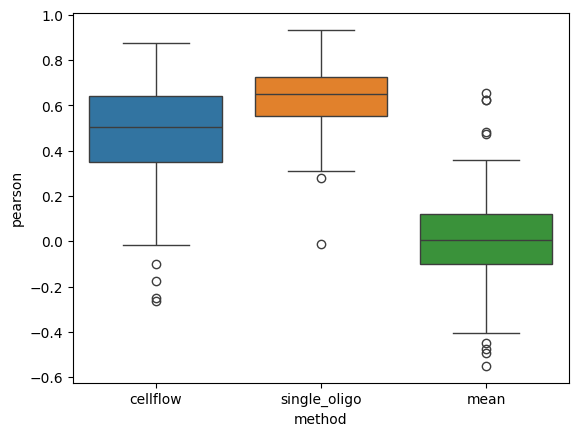

In [27]:
sns.boxplot(df_corrs_conditions, x="method", y="pearson", hue="method")

In [28]:
df_corrs_conditions.to_csv(os.path.join(output_dir, "corrs_conditions_with_mean_model.csv"))